Completed iteration 0 with error <object type:float64>.
Completed iteration 25 with error <object type:float64>.
Completed iteration 50 with error <object type:float64>.
Completed iteration 75 with error <object type:float64>.
Completed iteration 100 with error <object type:float64>.
Completed iteration 125 with error <object type:float64>.
Completed iteration 150 with error <object type:float64>.
Completed iteration 175 with error <object type:float64>.
Completed iteration 200 with error <object type:float64>.
Completed iteration 225 with error <object type:float64>.
Completed iteration 250 with error <object type:float64>.
Completed iteration 275 with error <object type:float64>.
Completed iteration 300 with error <object type:float64>.
Completed iteration 325 with error <object type:float64>.
Completed iteration 350 with error <object type:float64>.
Completed iteration 375 with error <object type:float64>.
Completed iteration 400 with error <object type:float64>.
Completed iteration

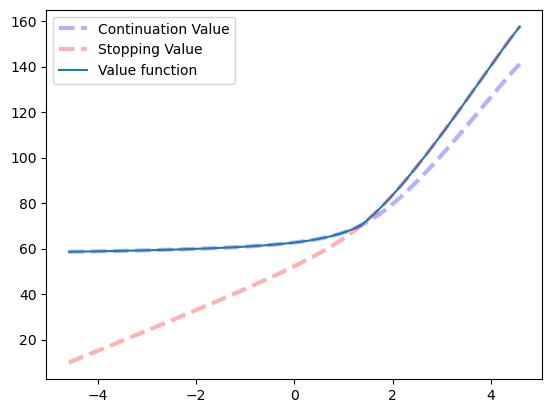

Completed iteration 0 with error <object type:float64>.
Completed iteration 25 with error <object type:float64>.
Completed iteration 50 with error <object type:float64>.
Completed iteration 75 with error <object type:float64>.
Completed iteration 100 with error <object type:float64>.
Completed iteration 125 with error <object type:float64>.
Completed iteration 150 with error <object type:float64>.
Completed iteration 175 with error <object type:float64>.
Completed iteration 200 with error <object type:float64>.
Completed iteration 225 with error <object type:float64>.
Completed iteration 250 with error <object type:float64>.
Completed iteration 275 with error <object type:float64>.
Completed iteration 300 with error <object type:float64>.
Completed iteration 325 with error <object type:float64>.
Completed iteration 350 with error <object type:float64>.
Completed iteration 375 with error <object type:float64>.
Completed iteration 400 with error <object type:float64>.
Completed iteration

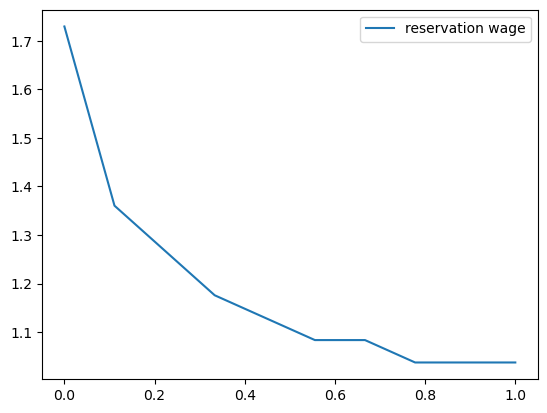

Execution time: 9.192701816558838 seconds


In [1]:
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#
#                Dynamic Programming by John Stachurski and Tom Sargent                      #
#                                                                                            #
# This code is used for Chapter 3 Markov Dynamics: Job Search Separation                     #
# IMPROVED VERSION USING NUMBA
# Written by Longye Tian 25/06/2024                                                          #
#--------------------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------------------#


#--------------------------------------------------------------------------------------------#
#                                   Import Libraries and packages                            #
#--------------------------------------------------------------------------------------------#

import numpy as np
from collections import namedtuple
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit
import time

#--------------------------------------------------------------------------------------------#
#                          CREATE NAMEDTUPLE TO STORE MODEL PARAMETERS                       #
#--------------------------------------------------------------------------------------------#

Job_Search_Separation = namedtuple("job_search_separation", 
                               ("n",                           # wage grid size
                                "m",                           # number of std
                                "ρ",                           # wage persistence
                                "ν",                           # wage volatility coefficent
                                "β",                           # discount factor
                                "α",                           # separation rate
                                "c"                            # unemployment compensation
                               ))      

def create_job_search_separation_model(n=200, m=10,ρ=0.9, ν=0.2, β=0.98,α=0.1,c=1.0):
    return Job_Search_Separation(n=n,m=m,ρ=ρ, ν=ν, β=β, α=α,c=c)


#--------------------------------------------------------------------------------------------#
#                                      NORMAL CDF                                            #
#--------------------------------------------------------------------------------------------#

@njit
def norm_cdf(x, mean=0, std=1):
    # Transform x to the standard normal
    z = (x - mean) / std
    
    # Use the Abramowitz & Stegun approximation for standard normal
    t = 1 / (1 + 0.2316419 * np.abs(z))
    d = 0.3989423 * np.exp(-z * z / 2)
    p = d * t * (0.3193815 + t * (-0.3565638 + t * (1.781478 + t * (-1.821256 + t * 1.330274))))
    
    return 1 - p if z > 0 else p



#--------------------------------------------------------------------------------------------#
#                                TAUCHEN DISCRETIZATION                                      #
#--------------------------------------------------------------------------------------------#

@njit
def Tauchen(job_search_separation):  
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    σ_w = np.sqrt(ν**2/(1-ρ**2))                               # W's std
    W = np.linspace(-m*σ_w, m*σ_w, n)                          # State space by Tauchen
    s = (W[n-1]-W[0])/(n-1)                                    # gap between two states
    P = np.zeros((n,n))                                        # Initialize P
    for i in range(n):
        P[i,0] = norm_cdf(W[0]-ρ*W[i]+s/2, std=σ_w)            # j=1
        P[i,n-1] = 1 - norm_cdf(W[n-1]-ρ*W[i]-s/2, std=σ_w)    # j=n
        for j in range(1,n-1):
            P[i,j] = norm_cdf(W[j]-ρ*W[i]+s/2, std=σ_w)-norm_cdf(W[j]-ρ*W[i]-s/2, std=σ_w)
    return W,P


# job_search_separation = create_job_search_separation_model
# W,P = Tauchen(job_search_separation)



#--------------------------------------------------------------------------------------------#
#                    BELLMAN OPERATOR IN JOB SEARCH MDOEL WITH SEPARATIOn                    #
#--------------------------------------------------------------------------------------------#

@njit
def T (v, job_search_separation):
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    W,P = Tauchen(job_search_separation)                       # Get W and P
    h = c + β * (P@v)                                          # Continuation value
    s = (1/(1-β*(1-α))) * (W+α*β*(P@v))                        # Stopping value
    return np.maximum(s,h)


#--------------------------------------------------------------------------------------------#
#                                   v-greedy policy                                          #
#--------------------------------------------------------------------------------------------#

@njit
def get_greedy (v, job_search_separation): 
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    W,P = Tauchen(job_search_separation)                       # Get W and P
    h = c + β * (P@v)                                          # Continuation value
    s = (1/(1-β*(1-α))) * (W+α*β*(P@v))                        # Stopping value
    σ= np.where(s>=h, 1, 0)                                      
    return σ

#--------------------------------------------------------------------------------------------#
#                                SUCCESSIVE APPROXIMATION                                    #
#--------------------------------------------------------------------------------------------#

@njit
def successive_approx (T,                                        # A callable operator
                       v_init,                                   # Initial condition
                       job_search_separation,                    # Model parameter
                       tol = 1e-6,                               # Error tolerance
                       max_iter = 10_000,                        # max iterations
                       print_step = 25                           # Print at multiples of print_step
                      ):
    v = v_init                                                   # set the initial condition
    error = tol + 1                                              # Initialize the error
    k = 0                                                        # initialize the iteration
    
    while error > tol and k < max_iter: 
        new_v = T(v,job_search_separation)                       # update by applying operator T
        error = np.max(np.abs(new_v-v))                          # update the error
        if k % print_step == 0:                                   
            print(f"Completed iteration {k} with error {error}.") 
        v = new_v                                                # update x
        k += 1                                                   # update the steps
    if error <= tol:                                    
        print(f"Terminated successfully in {k} interations.")
    else:     
        print("Warning: hit iteration bound.")
    return v   

#--------------------------------------------------------------------------------------------#
#                                 VALUE FUNCTION ITERATION                                   #
#--------------------------------------------------------------------------------------------#

@njit
def value_function_iteration (job_search_separation):
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    v_init = np.zeros(n)                                       # initialize Value function
    v_star = successive_approx(T, v_init, job_search_separation)    
    σ_star = get_greedy(v_star, job_search_separation)         # σ* is v*-greedy
    return v_star, σ_star


# job_search_separation = create_job_search_separation_model()
# value_function_iteration (job_search_separation)


#--------------------------------------------------------------------------------------------#
#                      PLOT CONTINUATION, STOPPING AND VALUE FUNCTIONS                       #
#--------------------------------------------------------------------------------------------#

def plot_value_stopping_continue (job_search_separation):
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    W,P= Tauchen(job_search_separation)                        # Get W and P
    v_star, σ_star = value_function_iteration(job_search_separation) 
    h = c + β * (P@v_star)                                     # Continuation value
    s = (1/(1-β*(1-α))) * (W+α*β*(P@v_star))                   # Stopping value
    plt.plot(W, h, linewidth=3, linestyle='--', color='blue', alpha=0.3,label='Continuation Value')
    plt.plot(W, s, linewidth=3, linestyle='--', color='red', alpha=0.3,label='Stopping Value')
    plt.plot(W, v_star, label='Value function')
    plt.legend()
    plt.show()
    
# job_search_separation = create_job_search_separation_model()
# plot_value_stopping_continue (job_search_separation) 

#--------------------------------------------------------------------------------------------#
#                         RESERVATION WAGE VS SEPARATION RATE                                #
#--------------------------------------------------------------------------------------------#

def reservation_separation (α_min=0,α_max=1,steps=10):
    A = np.linspace(α_min,α_max,steps)                         # alpha space
    Σ = np.zeros(steps)                                        # Initialize Policies
    for i in range(steps):
        job_search_separation = create_job_search_separation_model(α=A[i])
        W,P = Tauchen(job_search_separation)
        v_star,σ_star = value_function_iteration (job_search_separation)
        for index, element in enumerate(σ_star):
            if element>=1:
                Σ[i] = W[index]
                break
    plt.plot(A,Σ, label='reservation wage')
    plt.legend()
    plt.show()
    
#--------------------------------------------------------------------------------------------#
#                         RESERVATION WAGE VS SEPARATION RATE VERSION 2                      #
#--------------------------------------------------------------------------------------------#

@njit
def reservation_wage(job_search_separation):
    n,m,ρ,ν,β,α,c = job_search_separation                      # Unpack model parameters
    W,P = Tauchen(job_search_separation)
    v_star,σ_star = value_function_iteration (job_search_separation)
    for index, element in enumerate(σ_star):
            if element>=1:
                return W[index]
             

def reservation_separation_version_2(α_min=0,α_max=1,steps=20):
    A = np.linspace(α_min,α_max,steps)                         # alpha space
    Σ = np.zeros(steps)                                        # Initialize Policies
    for i in range(steps):
        job_search_separation = create_job_search_separation_model(α=A[i])
        Σ[i] = reservation_wage(job_search_separation)
    plt.plot(A,Σ, label='reservation wage')
    plt.legend()
    plt.show()
    
#--------------------------------------------------------------------------------------------#
#                                         PLAYGROUND                                         #
#--------------------------------------------------------------------------------------------#

start_time = time.time()

#------------ON YOUR MARKS---------SET----------------BANG!----------------------------------#


job_search_separation = create_job_search_separation_model()
plot_value_stopping_continue (job_search_separation)
reservation_separation ()


#-------------------------------------------------------------------------------------------#
end_time = time.time()

print(f"Execution time: {end_time - start_time} seconds")